# Processor for Fiducial Detection

This Notebook is testing the fiducial detection processor in DataSTORM.

In [1]:
# Standard initialization
%pylab
%matplotlib inline
import pandas as pd
from pathlib import Path
import trackpy as tp

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import test dataset
fileName = Path('../test-data/acTub_COT_gain100_30ms/acTub_COT_gain100_30ms.csv')
with open(str(fileName), 'r') as file:
    testData = pd.read_csv(file)

In [3]:
testData.describe()

,x,x-uncertainty,y,y-uncertainty,frame,ad-count,chi-square,background
count,214717.000000,214717.000000,214717.000000,214717.000000,214717.000000,214717.000000,214717.000000,214717.000000
mean,2425.196663,35.420145,2182.946881,35.420145,5172.075346,6288.638717,1029.127987,744.422318
std,1595.345619,20.475942,1322.208205,20.475942,2777.221724,15586.487514,2896.254531,312.086668
min,0.000001,0.847267,0.000002,0.847267,0.000000,338.324000,50.035500,523.371000
25%,965.218000,20.430100,982.750000,20.430100,2904.000000,577.636000,222.657000,613.929000
50%,2403.570000,38.192700,2206.350000,38.192700,5165.000000,772.204000,304.708000,656.426000
75%,3892.590000,50.197000,3461.780000,50.197000,7563.000000,1596.560000,433.924000,730.572000
max,4900.000000,80.431400,4200.000000,80.431400,9999.000000,177421.000000,58298.300000,7147.530000


## Group localizations in time

Now that we have the data, let's merge the localizations together by those that fall within a certain distance and a given time. We'll use TrackPy for this because DataSTORM's Merger does some unnecessary stuff. Merger is designed to specifically merge localization data, which includes some additional steps like adding photons and uncertainty handling which complicate matters. For now, we'll stick with what is most simple.

In [5]:
# Merge localizations
mergeRadius = 90
offTime     = 3
mergedLocs  = tp.link_df(testData, mergeRadius, memory = offTime)

Frame 9999: 18 trajectories present


Now we can assume that fiducial tracks are relatively long-lived, so let's remove short trajectories from the DataFrame using TrackPy's *filter_stubs()* function. First we'll look at the histogram of track lengths.

In [23]:
trackLengths = mergedLocs.groupby('particle').size()

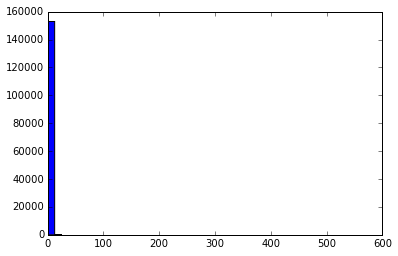

In [25]:
plt.hist(trackLengths, bins= 50)
plt.show()

OK, so most tracks are probably single molecules. What happens when we filter out the tracks with less than, say, ten localizations?

In [58]:
minimumTrackLength = 20

# Note that TrackPy's *filter_stubs()* function seems a bit slow.
# Perhaps pure Pandas with groupby filering would work better?
mergedFilteredLocs = tp.filter_stubs(mergedLocs, minimumTrackLength)

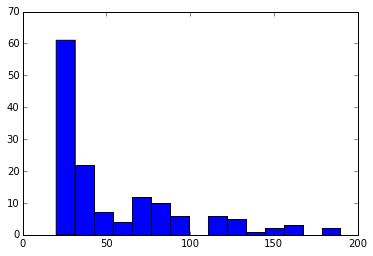

In [84]:
# Plot the histogram of track lengths after filtering by a minimum number
newTrackLengths = mergedFilteredLocs.groupby('particle').size()
plt.hist(newTrackLengths.as_matrix(), bins = 50)
plt.xlim((0,200))
plt.show()

In [60]:
mergedFilteredLocs.describe()

,x,x-uncertainty,y,y-uncertainty,frame,ad-count,chi-square,background,particle
count,11360.000000,11360.000000,11360.000000,11360.000000,11360.000000,11360.000000,11360.000000,11360.000000,11360.000000
mean,1833.148908,5.652357,2608.253449,5.652357,4924.509067,12413.902974,1515.262531,793.742109,69683.813908
std,834.169824,4.662703,579.472234,4.662703,2859.691174,10019.025155,2550.601730,173.610595,46178.593113
min,0.000019,0.977764,0.001299,0.977764,105.000000,438.225000,87.973200,564.622000,849.000000
25%,1569.650000,3.668713,2527.217500,3.668713,2360.750000,8719.275000,604.038250,693.159000,23728.000000
50%,1580.325000,4.210030,2556.830000,4.210030,4748.500000,11157.150000,755.401500,735.669000,58371.000000
75%,1595.212500,5.118940,2580.322500,5.118940,7494.250000,13757.125000,1146.747500,828.552000,113458.000000
max,4900.000000,75.082800,4200.000000,75.082800,9999.000000,140588.000000,34351.100000,2832.460000,152017.000000


## Spatial clustering of tracks

Now let's see whether the centers of mass of these tracks correspond to the actual fiducial location.

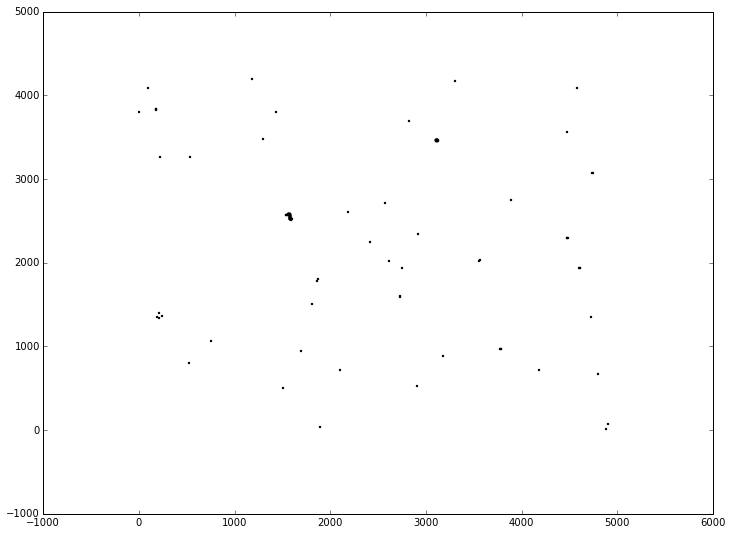

In [83]:
# Plot the centers of mass of the tracks
candidates   = mergedFilteredLocs.groupby('particle')
clusterStats = candidates.aggregate(np.mean)

fig = plt.figure(figsize = (12,9))
plt.scatter(clusterStats['x'], clusterStats['y'], s=2)
plt.show()

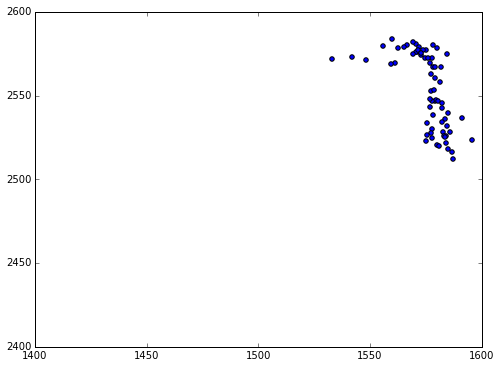

In [62]:
fig = plt.figure(figsize = (8,6))
plt.scatter(clusterStats['x'], clusterStats['y'])
plt.xlim((1400, 1600))
plt.ylim((2400, 2600))
plt.show()

The cluster around (1500, 2500) corresponds to the real fiducial, but I only know this because I have seen the raw tiff stack.

Before seeing if we can isolate this set of points automatically, let's see what the combined fiducial tracks look like...

In [67]:
temp = mergedFilteredLocs[np.logical_and(mergedFilteredLocs['x'] > 1500, mergedFilteredLocs['x'] < 1700)]
temp = temp[np.logical_and(temp['y'] > 2500, temp['y'] < 2600)]

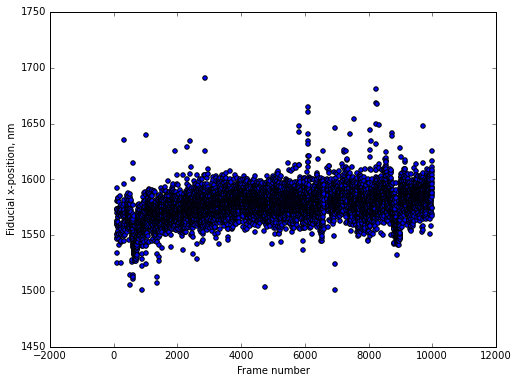

In [80]:
plt.figure(figsize = (8,6))
plt.scatter(temp['frame'], temp['x'])
plt.xlabel('Frame number')
plt.ylabel('Fiducial x-position, nm')
plt.show()

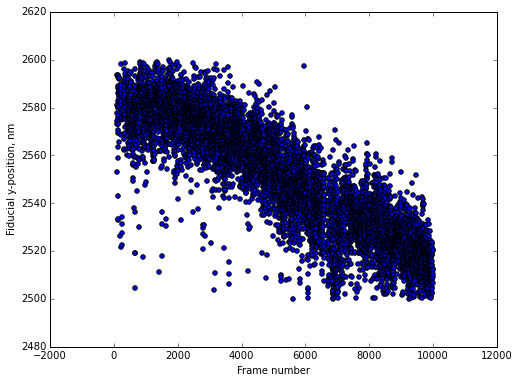

In [79]:
plt.figure(figsize = (8,6))
plt.scatter(temp['frame'], temp['y'])
plt.xlabel('Frame number')
plt.ylabel('Fiducial y-position, nm')
plt.show()

These results match qualitatively with Niklas's fiducial detection on this dataset, though I would say that what is in this notebook is currently a bit more noisy than Niklas's results.

Let's now try automatic detection of the fiducials. We can apply two pieces of knowledge here to identify the fiducials:

1. The final fiducial track should span most of the full image stack
2. The fiducial track cannot contain localizations with the same frame numbers

A problem might arise if two tracks are clustered together but contain the same frame numbers. One way to circumvent this problem is to remove both tracks. Another is to keep the longer track, though this does not guarantee we chose the correct one. Yet another option is to reject both tracks unless one is especially long-lived, such as one track of length 20 vs. one track of length 100. This would require another free parameter, but would likely guarantee that the longer track was the correct one.

After clustering, we can check that the final track spans the full stack by saying that it must be at least half as long as the full stack length. I can't suspect that false positive rates will not be very high at the end of this routine.

One other quick note is that we can cluster by the tracks' centers of mass or by the all the localizations together. It may be better to cluster by all the localizations instead of their centers of mass since a very good fiducial may consist of only one track and would not therefore appear as a spatial cluster of tracks.

In [85]:
# Perform spatial clustering with min_pts = half the stack length
#TODO: implement DBSCAN or something similar to do this